# Plot Edward's Track from AVISO

Author: LJK 

In [1]:
import earthaccess
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.ndimage import generic_filter
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata

In [2]:
# Set default fontsizes for plots
fontsize = 18

plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title

### Open AVISO eddy dataset for Edward

In [3]:
aviso_ds = xr.open_dataset('Edward_Eddy_trajectory_nrt_3.2exp_cyclonic_20180101_20240723.nc')
aviso_ds

<xarray.Dataset> Size: 202kB
Dimensions:                        (obs: 223, NbSample: 20)
Dimensions without coordinates: obs, NbSample
Data variables: (12/27)
    amplitude                      (obs) float64 2kB ...
    effective_area                 (obs) float32 892B ...
    effective_contour_height       (obs) float32 892B ...
    effective_contour_latitude     (obs, NbSample) float64 36kB ...
    effective_contour_longitude    (obs, NbSample) float64 36kB ...
    effective_contour_shape_error  (obs) float64 2kB ...
    ...                             ...
    speed_contour_longitude        (obs, NbSample) float64 36kB ...
    speed_contour_shape_error      (obs) float64 2kB ...
    speed_radius                   (obs) float64 2kB ...
    time                           (obs) datetime64[ns] 2kB ...
    track                          (obs) uint32 892B ...
    uavg_profile                   (obs, NbSample) float64 36kB ...
Attributes: (12/19)
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    comment:                   Surface product; mesoscale eddies
    creator_email:             aviso@altimetry.fr
    creator_url:               https://www.aviso.altimetry.fr
    date_created:              2024-08-06T09:38:06Z
    framework_used:            https://github.com/AntSimi/py-eddy-tracker
    ...                        ...
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    summary:                   This dataset contains eddy atlas from all-sate...
    time_coverage_duration:    P2396D
    time_coverage_end:         2024-07-23T00:00:00Z
    time_coverage_start:       2018-01-01T00:00:00Z
    title:                     Mesoscale Cyclonic Eddies in Altimeter Observa...

In [4]:
dates = [i for i in aviso_ds.time.values] # these are sorted already
print(min(dates))
print(max(dates)) # still existed at the end of the dataset

2023-12-14T00:00:00.000000000
2024-07-23T00:00:00.000000000


In [5]:
center_lats = [i for i in aviso_ds.latitude.values]
center_lons = [i for i in aviso_ds.longitude.values]
print(len(center_lats))

223


In [6]:
print(min(center_lats))
print(max(center_lats))
print(min(center_lons)-360)
print(max(center_lons)-360)

35.502697
36.847385
-71.77410888671875
-67.88714599609375


In [7]:
def get_eddy_by_ID_date(ds,eddy_date):
    """
    ds: netCDF AVISO format
    track_id: id of eddy to extract
    eddy_date: date in format 'YYYY-MM-DD'

    Returns contour lons, contour lats, center lon, center lat
    """
    try:
        ind = np.where(ds.time == np.datetime64(eddy_date))[0][0]
        contour_lons = np.array(ds.effective_contour_longitude[ind])
        contour_lats = np.array(ds.effective_contour_latitude[ind])
    except:
        print('No eddy data available with that request ... :(')        
    
    return contour_lons,contour_lats,ds.longitude[ind],ds.latitude[ind]

## Eddy timeseries

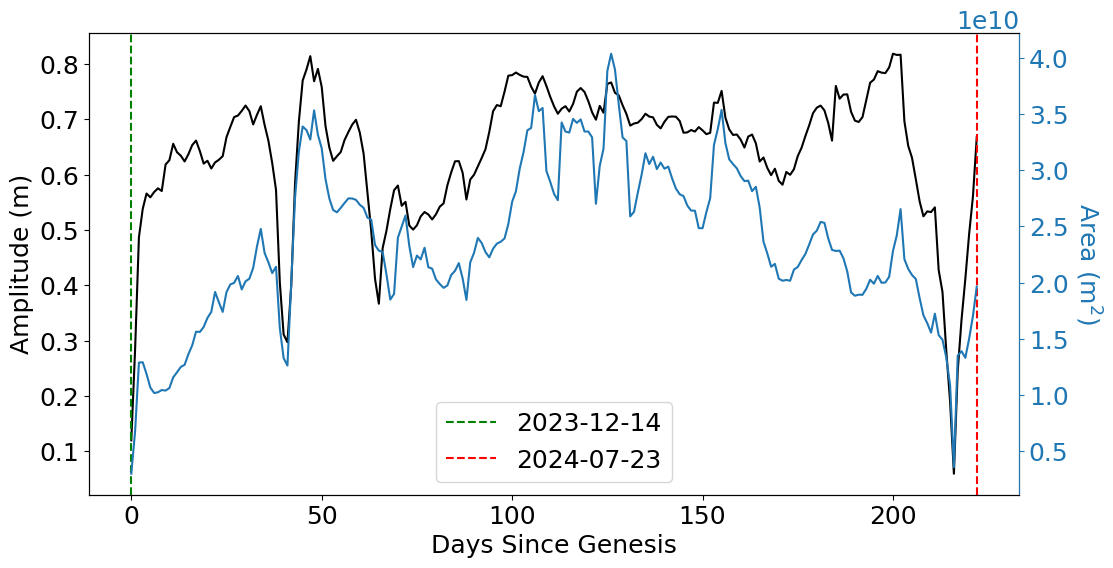

In [8]:
fig,ax = plt.subplots(figsize=(12,6))

p0 = ax.plot(aviso_ds.amplitude,c='k')
ax.set_ylabel('Amplitude (m)')

axa_color = 'C0'
axa = ax.twinx()
p1 = axa.plot(aviso_ds.effective_area,c=axa_color)
axa.set_ylabel('Area (m$^2$)',rotation=270,labelpad=25)

axa.yaxis.label.set_color(axa_color)          #setting up Y-axis label color to blue
axa.tick_params(axis='y', colors=axa_color)  #setting up Y-axis tick color to black
axa.spines['right'].set_color(axa_color)        # setting up Y-axis tick color to red

ax.set_xlabel('Days Since Genesis')

ax.axvline(0,0,1,linestyle = '--', c='g', label=str(min(dates))[0:10])
ax.axvline(len(aviso_ds.effective_area)-1,0,1,linestyle = '--', c='r', label=str(max(dates))[0:10])

ax.legend()

plt.show()

### Find the SWOT days with 2 passes over the eddy area

In [9]:
auth = earthaccess.login(persist=True)

In [10]:
def get_swot_data(latmin,latmax,lonmin,lonmax,tmin,tmax):
    """
    Searches for SWOT data within the bounding box and time. Note that this doesn't work for unsmoothed data. 
    
    latmin,latmax: latitude bounds, degrees N (south is negative); floats
    lonmin, lonmax: longitude bounds, degrees E (west is negative); floats
    tmin,tmax: temporal bounds; strings of form 'yyyy-mm-dd'
    """
    bbox = (lonmin, latmin, lonmax, latmax) # lonW, latS, lonE, latN
    results = earthaccess.search_data(
        short_name="SWOT_L2_LR_SSH_EXPERT_2.0",
        bounding_box=bbox,
        temporal=(tmin,tmax))
    
    print("Number of swaths: " + str(len(results))) # not daily files, so will likely be more than # of days
    paths = earthaccess.open(results) # is there a way to choose a subset of variables here?

    return paths

In [11]:
latmin,latmax = 34,37
lonmin,lonmax = -73,-68
tmin,tmax = '2023-12-14','2024-07-23' 
edward_paths = get_swot_data(latmin,latmax,lonmin,lonmax,tmin,tmax)

Number of swaths: 163


QUEUEING TASKS | :   0%|          | 0/163 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/163 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/163 [00:00<?, ?it/s]

Get unique dates that have a swath in the path

In [12]:
dates_available = []
for i in edward_paths:
    today = str(i).split('-')[-1].split('_')[-4][0:8]
    if today not in dates_available:
        dates_available.append(today)
print(dates_available)

['20231214', '20231215', '20231217', '20240102', '20240103', '20240104', '20240105', '20240106', '20240113', '20240114', '20240115', '20240123', '20240124', '20240125', '20240126', '20240127', '20240203', '20240204', '20240205', '20240213', '20240214', '20240215', '20240216', '20240217', '20240224', '20240225', '20240226', '20240305', '20240306', '20240307', '20240309', '20240316', '20240317', '20240318', '20240326', '20240327', '20240328', '20240330', '20240405', '20240406', '20240407', '20240408', '20240416', '20240417', '20240418', '20240420', '20240426', '20240427', '20240428', '20240429', '20240507', '20240508', '20240509', '20240517', '20240518', '20240519', '20240527', '20240528', '20240529', '20240530', '20240607', '20240608', '20240609', '20240617', '20240618', '20240619', '20240620', '20240628', '20240629', '20240630', '20240708', '20240709', '20240710', '20240711', '20240719', '20240720', '20240721']


Version control to get the QC path for each swath

Note: not all swaths have a v2, and PGC0 is preferred over PIC0; documentation here: https://www.aviso.altimetry.fr/en/data/products/sea-surface-height-products/global/swot-karin-low-rate-ocean-products.html

In [13]:
edward_PGC0_paths,edward_PIC0_paths = [],[]

for p in edward_paths:
    if str(p).split('_')[-2] == 'PGC0':
        edward_PGC0_paths.append(p)
    else:
        edward_PIC0_paths.append(p)

print(len(edward_PGC0_paths))
print(len(edward_PIC0_paths))

26
137


Remove v1 if there's a v2, etc.

In [14]:
def remove_unneeded_versions(path_list):
    non_v1_paths = [i for i in path_list if int(str(i).split('_')[-1][0:2]) > 1]    
    for p in non_v1_paths:
        version = int(str(p).split('_')[-1][0:2])
        for v in np.arange(1,version): # remove all versions  less than the highest
            if str(p)[:-5] + str(v) + '.nc>' in path_list: # check if that earlier version is in list
                path_list.remove(str(p)[:-5] + str(v) + '.nc>')
    return path_list

In [15]:
# these lists will have one of each timestep
edward_PGC0_paths_filtered = remove_unneeded_versions(edward_PGC0_paths)
edward_PIC0_paths_filtered = remove_unneeded_versions(edward_PIC0_paths)

print(len(edward_PGC0_paths_filtered))
print(len(edward_PIC0_paths_filtered))

26
137


Now check if any of the PGC0 timestamps are in PIC0, then remove PIC0 filepath

In [16]:
edward_paths_filtered = []

for i in edward_PIC0_paths_filtered:
    match = 0
    for p in edward_PGC0_paths_filtered:
        if str(i).split('-')[-1].split('_')[-4] == str(p).split('-')[-1].split('_')[-4]: # same timestamp
            edward_paths_filtered.append(p)
            match = 1
            break
    if match == 0: # no match
        edward_paths_filtered.append(i)

print(len(edward_paths_filtered))

137


Paths are finally filtered, so we can look for true double pass dates

In [17]:
dates_available,double_passes = [],[]
dates_available_version_control = {}

ind = 0
for i in edward_paths_filtered:
    today = str(i).split('-')[-1].split('_')[-4][0:8]
    dates_available.append(today)
    if today not in dates_available_version_control:
        dates_available_version_control[today] = ind
    elif today not in double_passes:
        double_passes.append(today)
    ind += 1
    
print(len(dates_available))
print(len(double_passes))

137
49


## Plot eddy & SWOT data

Using calculations from “SWOT_velocities_over_PACE.ipynb”. Shouldn't need to regrid like this with L3 SWOT data

In [18]:
def get_path_inds_for_requested_date(paths,date_requested):
    inds = []
    ind = 0 
    for i in paths:
        today = str(i).split('-')[-1].split('_')[-4][0:8]
        if date_requested == today:
            inds.append(ind)
        ind += 1

    return inds    

In [19]:
def crop_dataset_by_lat_lon(ds,latmin,latmax,lonmin,lonmax):
    mask = (ds.latitude >= latmin) & (ds.latitude <= latmax) & (ds.longitude >= lonmin+360) & (ds.longitude <= lonmax+360)
    ds_masked = ds.where(mask, drop=True)
    return ds_masked

In [20]:
def crop_dataset_regrid(ds,latmin,latmax,lonmin,lonmax):

    # Crop dataset based on requested bounds
    mask = (ds.latitude >= latmin) & (ds.latitude <= latmax) & (ds.longitude >= lonmin+360) & (ds.longitude <= lonmax+360)
    ds_masked = ds.where(mask, drop=True)

    # Set up grid to project data onto
    res = 0.036
    if lonmin < 0:
        lonmin = lonmin+360
    if lonmax < 0:
        lonmax = lonmax+360
    
    xv = np.arange(lonmin,lonmax,res)
    yv = np.arange(latmin,latmax,res)
    grid_x, grid_y = np.meshgrid(xv,yv)

    # Grid the SLA data
    sla=ds_masked.ssha_karin_2+ds_masked.height_cor_xover
    lat=ds_masked.latitude
    lon=ds_masked.longitude
    grid_sla = griddata((lon.values.ravel(),lat.values.ravel()), sla.values.ravel(), (grid_x, grid_y), method='linear')
    
    return grid_sla,grid_x,grid_y

Copying these SWOT vel calculations from "SWOT_velocities_over_PACE.ipynb"

In [21]:
def compute_geos_current(grid_sla,grid_lat):
    """
    grid_sla: (m) Make sure this is first corrected with height_cor_xover from L2 data! 
    grid_lat: degrees N
    """
    
    omega = 7.2921159e-05  # angular velocity of the Earth [rad/s]
    fc = 2*omega*np.sin(grid_lat*np.pi/180.)
        
    # avoid zero near equator, bound fc by min val as 1.e-8
    f_coriolis = np.sign(fc)*np.maximum(np.abs(fc), 1.e-8)
    
    dx,dy = 4000,4000 # m i changed it to 4000 to match res? need to double check
    gravity = 9.81

    dsdy,dsdx=np.array(np.gradient(grid_sla, dx, edge_order=1))
    vg = (gravity/np.array(f_coriolis))*dsdx
    ug = -(gravity/np.array(f_coriolis))*dsdy
    geos_current = np.sqrt(ug**2 + vg**2)
    
    return ug,vg,geos_current

In [22]:
def plot_all_swaths_on_date(ax,date_requested,gridded=0):
    """
    date_requested: 'YYYYMMDD'
    gridded: 0 or 1 (aka no or yes)
    """
    
    inds = get_path_inds_for_requested_date(edward_paths_filtered,date_requested)
    for i in inds:
        swot_ds = xr.open_dataset(edward_paths_filtered[i])

        if gridded == 0:
            swot_ds_masked = crop_dataset_by_lat_lon(swot_ds,latmin,latmax+1,lonmin,lonmax+1)
            plot = ax.pcolormesh(swot_ds_masked.longitude-360,swot_ds_masked.latitude,swot_ds_masked.ssha_karin_2+swot_ds_masked.height_cor_xover,cmap='coolwarm',vmin=-1,vmax=1)
        elif gridded == 1:
            # Regrid the data uniformly
            grid_sla,grid_x,grid_y = crop_dataset_regrid(swot_ds,latmin,latmax+2,lonmin,lonmax+2)
            plot = ax.pcolormesh(grid_x-360,grid_y,grid_sla,cmap='coolwarm',vmin=-1,vmax=1)

            # Add in geotrophic velocity streamplot
            ug,vg,geos_current = compute_geos_current(grid_sla,grid_y)
            ax.streamplot(grid_x-360,grid_y,ug,vg, density = 3, color = 'k',linewidth=1)
    
    # plot AVISO eddy contour
    contour_lons,contour_lats,center_lon,center_lat = get_eddy_by_ID_date(aviso_ds,'%s-%s-%s'%(date_requested[0:4],date_requested[4:6],date_requested[6:8]))
    ax.plot(contour_lons-360,contour_lats,zorder=100,c='k',linewidth=2)

    return plot

NOTE: The double pass dates do not necessarily intersect the eddy, they were included if there was two passes in the box

Dates checked that don't cross eddy:
- '20231214',

In [23]:
double_passes

['20231214',
 '20240103',
 '20240104',
 '20240113',
 '20240114',
 '20240115',
 '20240124',
 '20240125',
 '20240203',
 '20240204',
 '20240214',
 '20240215',
 '20240224',
 '20240225',
 '20240226',
 '20240305',
 '20240306',
 '20240307',
 '20240316',
 '20240317',
 '20240327',
 '20240328',
 '20240406',
 '20240407',
 '20240416',
 '20240417',
 '20240418',
 '20240427',
 '20240428',
 '20240507',
 '20240508',
 '20240509',
 '20240517',
 '20240518',
 '20240519',
 '20240528',
 '20240529',
 '20240608',
 '20240609',
 '20240618',
 '20240619',
 '20240628',
 '20240629',
 '20240630',
 '20240709',
 '20240710',
 '20240719',
 '20240720',
 '20240721']

Text(0.5, 0, 'Longitude (E$^{\\circ}$)')

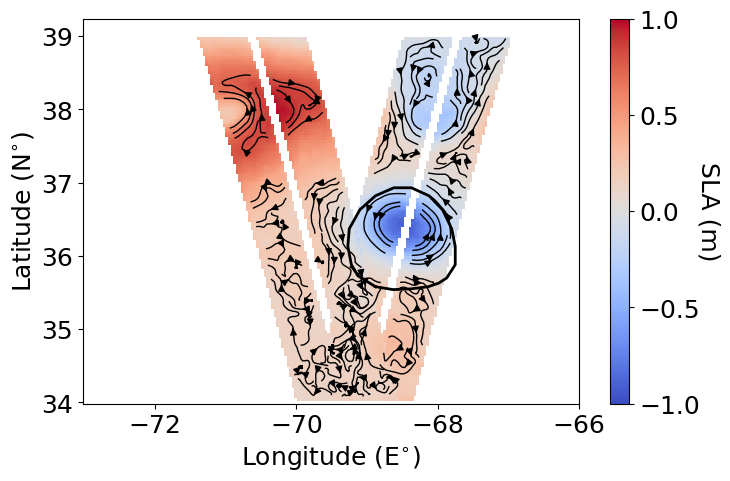

In [24]:
fig,ax=plt.subplots(figsize=(8,5))
plot = plot_all_swaths_on_date(ax,'20240103',1)
cbar = plt.colorbar(plot,ax=ax)
cbar.set_label('SLA (m)',rotation=270, labelpad=15)
ax.set_ylabel('Latitude (N$^{\circ}$)')
ax.set_xlabel('Longitude (E$^{\circ}$)')

Text(0.5, 0, 'Longitude (E$^{\\circ}$)')

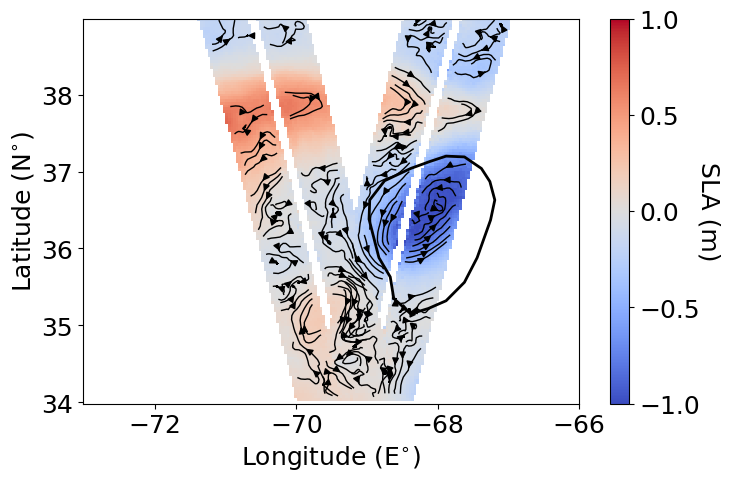

In [25]:
fig,ax=plt.subplots(figsize=(8,5))
plot = plot_all_swaths_on_date(ax,'20240214',1)
cbar = plt.colorbar(plot,ax=ax)
cbar.set_label('SLA (m)',rotation=270, labelpad=15)
ax.set_ylabel('Latitude (N$^{\circ}$)')
ax.set_xlabel('Longitude (E$^{\circ}$)')

Text(0.5, 0, 'Longitude (E$^{\\circ}$)')

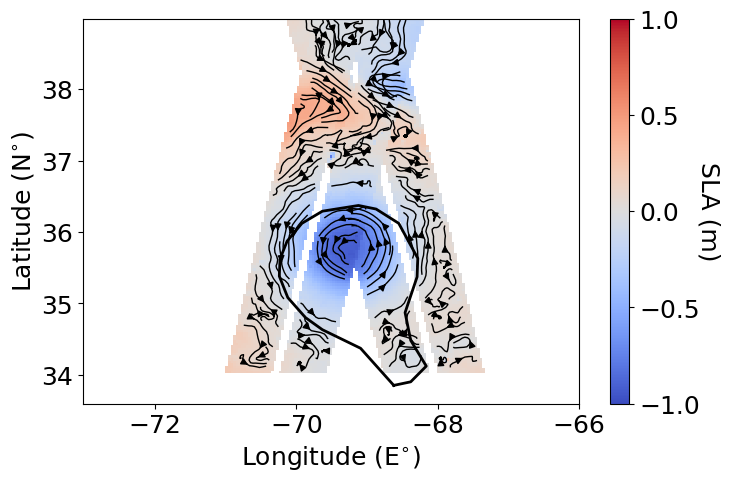

In [26]:
fig,ax=plt.subplots(figsize=(8,5))
plot = plot_all_swaths_on_date(ax,'20240406',1)
cbar = plt.colorbar(plot,ax=ax)
cbar.set_label('SLA (m)',rotation=270, labelpad=15)
ax.set_ylabel('Latitude (N$^{\circ}$)')
ax.set_xlabel('Longitude (E$^{\circ}$)')

Text(0.5, 0, 'Longitude (E$^{\\circ}$)')

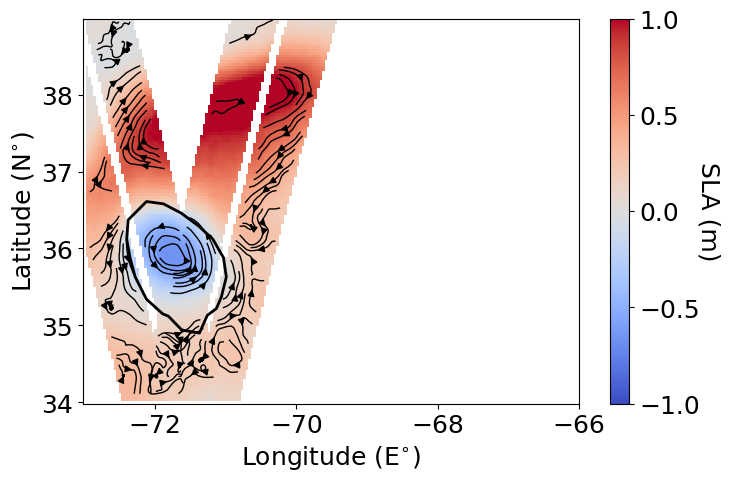

In [27]:
fig,ax=plt.subplots(figsize=(8,5))
plot = plot_all_swaths_on_date(ax,'20240710',1)
cbar = plt.colorbar(plot,ax=ax)
cbar.set_label('SLA (m)',rotation=270, labelpad=15)
ax.set_ylabel('Latitude (N$^{\circ}$)')
ax.set_xlabel('Longitude (E$^{\circ}$)')

### Eddy Transit Plot

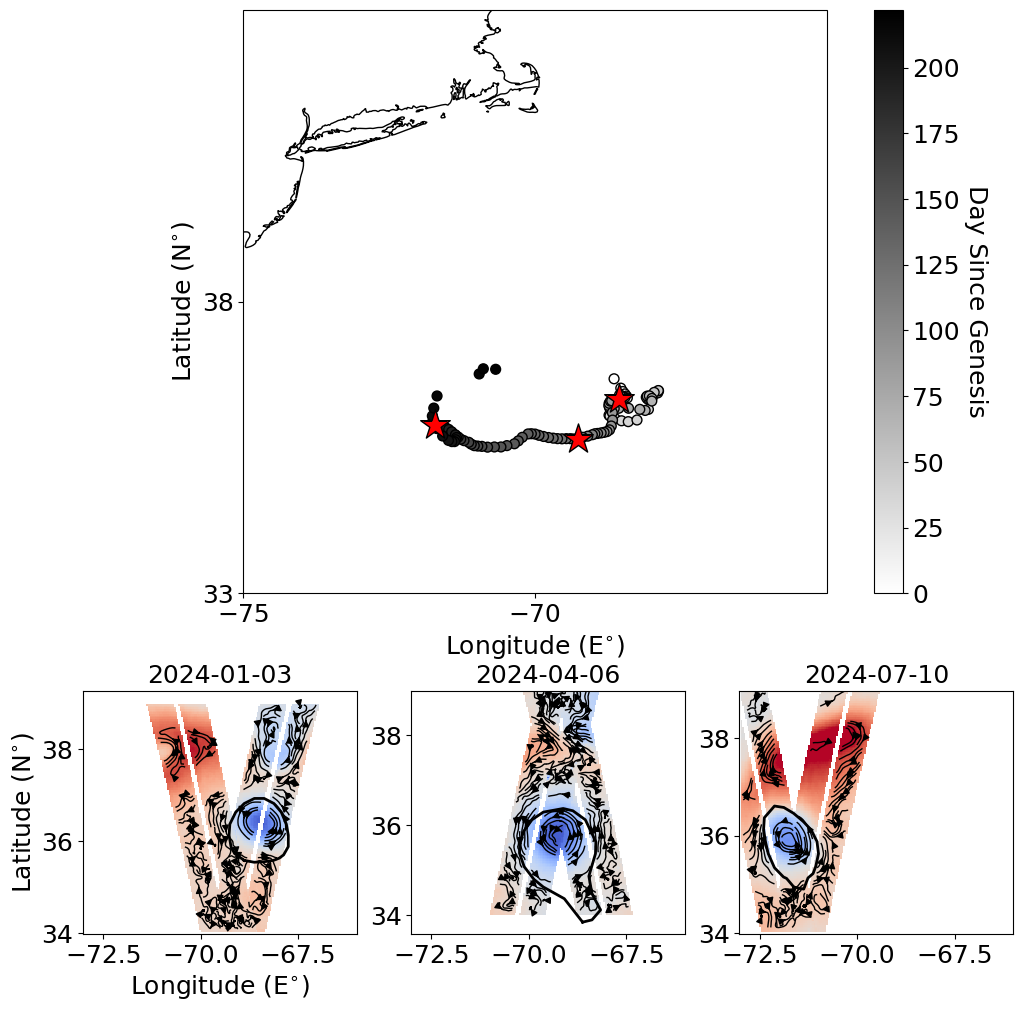

In [29]:
fig = plt.figure(figsize=(12, 12))
gs = fig.add_gridspec(nrows=3, ncols=3)
ax0 = fig.add_subplot(gs[:-1, :],projection=ccrs.PlateCarree())
ax1 = fig.add_subplot(gs[-1, 0])
ax2 = fig.add_subplot(gs[-1, 1])
ax3 = fig.add_subplot(gs[-1, 2])

plt.subplots_adjust(hspace=0.4)

#################### SWOT SUBPLOTS ####################

dates_to_plot = ['20240103','20240406','20240710']
#dates_to_plot = ['20240710','20240406','20240103'] # reverse the order 

plot = plot_all_swaths_on_date(ax1,dates_to_plot[0],1)
plot = plot_all_swaths_on_date(ax2,dates_to_plot[1],1)
plot = plot_all_swaths_on_date(ax3,dates_to_plot[2],1)

ind1 = np.where([d==np.datetime64('%s-%s-%s'%(dates_to_plot[0][0:4],dates_to_plot[0][4:6],dates_to_plot[0][6:8])) for d in dates])[0][0]
ind2 = np.where([d==np.datetime64('%s-%s-%s'%(dates_to_plot[1][0:4],dates_to_plot[1][4:6],dates_to_plot[1][6:8])) for d in dates])[0][0]
ind3 = np.where([d==np.datetime64('%s-%s-%s'%(dates_to_plot[2][0:4],dates_to_plot[2][4:6],dates_to_plot[2][6:8])) for d in dates])[0][0]

ax1.set_title('%s-%s-%s'%(dates_to_plot[0][0:4],dates_to_plot[0][4:6],dates_to_plot[0][6:8]))
ax2.set_title('%s-%s-%s'%(dates_to_plot[1][0:4],dates_to_plot[1][4:6],dates_to_plot[1][6:8]))
ax3.set_title('%s-%s-%s'%(dates_to_plot[2][0:4],dates_to_plot[2][4:6],dates_to_plot[2][6:8]))

#cax = ax3.add_axes([0.2, 0.0, 0.05, 0.8]) # x0, y0, width, height
#cbar = plt.colorbar(plot,ax=cax)
#cbar.set_label('SLA (m)',rotation=270, labelpad=15)

ax1.set_ylabel('Latitude (N$^{\circ}$)')
ax1.set_xlabel('Longitude (E$^{\circ}$)')

#################### MAP: ax0 ####################

skip = 2
scat = ax0.scatter(center_lons[::skip],center_lats[::skip],s=50,edgecolor='k',c=np.arange(0,len(dates))[::skip],cmap='binary') #small dots of every date

highlight_lons,highlight_lats = [],[]

count = 0
for d in dates_to_plot:
    ind = np.where([i==np.datetime64('%s-%s-%s'%(d[0:4],d[4:6],d[6:8])) for i in dates])[0][0]
    ax0.scatter(center_lons[ind],center_lats[ind],marker='*',c='r',s=500,edgecolor='k')
        
    count += 1

xmin,xmax = -75,-65
ymin,ymax = 33,43

ax0.coastlines()
ax0.set_xlim([xmin,xmax])
ax0.set_ylim([ymin,ymax])
ax0.set_xticks(range(xmin,xmax, 5)) 
ax0.set_yticks(range(ymin,ymax, 5)) 

ax0.set_ylabel('Latitude (N$^{\circ}$)')
ax0.set_xlabel('Longitude (E$^{\circ}$)')

# Colorbar
cbar = plt.colorbar(scat, ax=ax0)
cbar.set_label('Day Since Genesis',rotation=270,labelpad=20)

plt.show()